<a href="https://colab.research.google.com/github/saluisto/FINIFLUX/blob/main/gpinn2_generic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 10.0 MB/s eta 0:00:00
No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



Compiling model...
Building feed-forward neural network...
'build' took 0.141762 s

'compile' took 2.614765 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [4.61e-01, 9.99e-02, 1.01e-01, 3.07e+00, 2.97e+04]    [4.61e-01, 9.99e-02, 1.01e-01, 3.07e+00, 2.97e+04]    []  
29        [4.61e-01, 9.99e-02, 1.01e-01, 3.07e+00, 2.97e+04]    [4.61e-01, 9.99e-02, 1.01e-01, 3.07e+00, 2.97e+04]    []  

Best model at step 0:
  train loss: 2.97e+04
  test loss: 2.97e+04
  test metric: []

'train' took 10.796861 s

Compiling model...
'compile' took 2.439215 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
29        [4.61e-01, 9.99e-02, 1.01e-01, 3.07e+00, 2.97e+04]    [4.61e-01, 9.99e-02, 1.01e-01, 3.07e+00, 2.97e+04]    []  
1000      [8.19e-08, 5.44e-07, 1.30e-06, 1.15e-08, 5.52e+02]   

KeyboardInterrupt: 

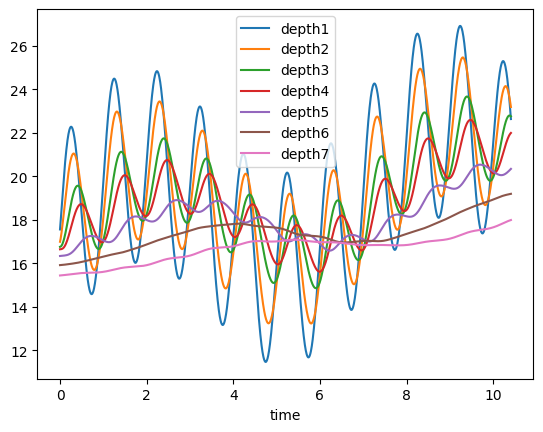

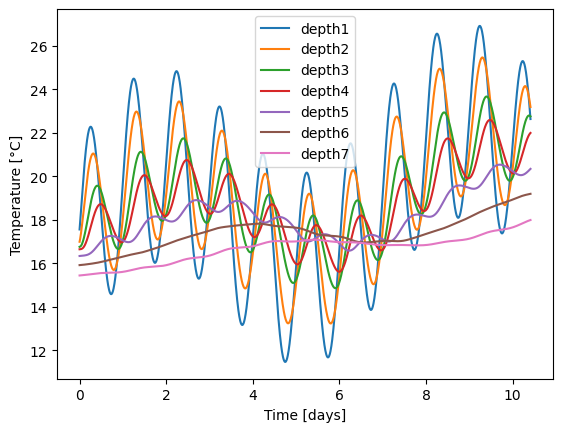

In [1]:
!pip install deepxde
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf

#%% This section reads the measured temperature in different depths to setup the boundary conditions and
# to solve for the advective flow velocity

def read_data(filename):
    df = pd.read_csv(filename)
    obs_data = df.dropna()
    obs_data=obs_data.drop(index=range(4))
    return obs_data

df=read_data(filename='daily_fluc_q.csv')

df['time'] = pd.to_datetime(df['time'], format="%d/%m/%Y %H:%M:%S")
#df = df.drop('depth1', axis=1)
first_time = df['time'].min()
df['time'] = df['time'] - first_time

df=df.iloc[:1500]

# convert from days into seconds
df['time'] = df['time'].dt.total_seconds()/(60*60*24)
tmaxx=np.float32(df['time'].max())
tmax = dde.Variable(tmaxx)

time = df['time'].values.reshape(-1,1)

df.set_index('time', inplace=True)

# observation depths
observe_x = np.array([0,0.21,0.42,0.62,0.82,1.01,1.22]).reshape(-1,1)
observe_T = df[['depth1','depth2','depth3','depth4','depth5','depth6','depth7']].values

LL=np.float32(observe_x[len(observe_x)-1])
L = dde.Variable(LL)


df.plot()
ax=df.plot()
ax.set_xlabel("Time [days]")
ax.set_ylabel("Temperature [°C]")
#%%
# In this section the part of the objective function is beeing defined that is associated withe the pdf (heat transport equation)

def pde(x, y):

    phi = 0.35 # porosity, unitless
    roh_water=1028
    roh_sed=2650
    c_water=4068
    c_sed= 792.45
    ke=1.68*60*60*24 #ke is converted from J/(s m K) to J/(day m K)

    Cw = c_water*roh_water
    Csed = c_sed*roh_sed

    Cs = phi*Cw + (1-phi)*Csed


    D=ke/(Cs)

    a=Cw/(Cs)


    #Output of the NN is the temperature field T and q fluxes in time
    T, q = y[:, 0:1], y[:, 1:2]

    #derivatives that are needed for the heat transport equation

    dy_t = dde.grad.jacobian(y, x, i=0, j=1)  #i=0 means component of y --> i=0 Temperature i=1 q; j=0 is z and j=1 time
    dy_xx = dde.grad.hessian(y, x, component=0, i=0, j=0) #compoent = 0 is Temperature component = 1 is q
                                                          #x i,j = 0 is depth z i,j = 1 is time t meant is xi,xj

    dy_dx = dde.grad.jacobian(y, x, i=0, j=0)

    dy_tx = dde.grad.hessian(y, x, component=0, i=1, j=0)
    dy_tt = dde.grad.hessian(y, x, component=0, i=1, j=1)

    dy_xxx =dde.grad.jacobian(dy_xx, x, i=0, j=0)
    dy_xxt =dde.grad.jacobian(dy_xx, x, i=0, j=1)

    dq_dx=dde.grad.jacobian(y, x, i=1, j=0)
    dq_dt=dde.grad.jacobian(y, x, i=1, j=1)
    dq_xt = dde.grad.hessian(y, x, component=1, i=0, j=1)
    dq_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    dy_xt=dde.grad.hessian(y, x, component=0, i=0, j=1)

    return [dy_t-D*dy_xx+a*q*dy_dx+a*T*dq_dx,
            dy_tx-D*dy_xxx+a*dq_dx*dy_dx+a*q*dy_xx+a*dy_dx*dq_dx+a*T*dq_xx,
            dy_tt-D*dy_xxt+a*dq_dt*dy_dx+a*q*dy_xt+a*dy_t*dq_dx+a*T*dq_xt,
            dq_dx]




#%%
#Define where observations are located and define IC and BC



xx, tt = np.meshgrid(observe_x,time)
X = np.vstack((np.ravel(xx), np.ravel(tt))).T #x,t


train_set=1
set_cout=int(train_set*len(tt))
X_train = np.vstack((np.ravel(xx[:set_cout]), np.ravel(tt[:set_cout]))).T #x,t
observe_T=np.ravel(observe_T[:set_cout]).reshape(-1,1)
observe_u = dde.icbc.PointSetBC(X_train,observe_T,component=0)





#%% Define the model gometry in space and time

max_time=tmaxx
geom = dde.geometry.Interval(0,LL)
timedomain = dde.geometry.TimeDomain(0, max_time)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

#%
data = dde.data.TimePDE(
    geomtime,
    pde,
    [observe_u],
    num_domain=0,
    anchors=X,
)

# Here different neural network structures are beeing tested PFNN are
# DeepONET networks /(https://www.nature.com/articles/s42256-021-00302-5)

net = dde.nn.PFNN([2, [40, 40], [40, 40], [40, 40], [40, 40], 2], "tanh", "Glorot uniform")
#net = dde.nn.PFNN([2, [40, 30], [40, 30], [40, 30], 2], "tanh", "Glorot uniform")
#net = dde.nn.PFNN([2, [100, 100], [100, 100], [100, 100], 2], "tanh", "Glorot uniform")
#net = dde.nn.PFNN([2, [10, 50], [10, 50], [10, 50], 2], "tanh", "Glorot uniform")
#net = dde.nn.FNN([2, [200, 200], [200, 200], 2], "tanh", "Glorot uniform")
#net = dde.nn.PFNN([2, [200, 200], [200, 200], 2], "tanh", "Glorot uniform")
#net = dde.nn.PFNN([2, [50, 50], [50, 50], 2], "tanh", "Glorot uniform")


model = dde.Model(data, net)

#dde.config.set_default_float("float32")

#model.compile("adam", lr=0.01,loss_weights=[1, 1, 1, 100, 100])
#model.restore("backup\model.ckpt")

iterations=100000
runs=7

for i in range(runs):
  model.compile("L-BFGS-B",loss_weights=[1, 1, 1, 100, 100])
  losshistory, train_state = model.train()

  model.compile("adam", lr=0.0001,loss_weights=[1, 1, 1, 100, 100])
  losshistory, train_state = model.train(iterations=iterations)

#iterations=100000
#model.compile("adam", lr=0.001,loss_weights=[1, 1, 1, 100, 100])
#losshistory, train_state = model.train(iterations=iterations)

#iterations=200000
#model.compile("adam", lr=0.0001,loss_weights=[1, 1, 1, 100, 100])
#losshistory, train_state = model.train(iterations=iterations)

#model.compile("L-BFGS-B",loss_weights=[1, 1, 1, 100, 100])
#losshistory, train_state = model.train()



# I am using a two step learning procedure. Here is the second step using L-BFGS-B
#model.compile("L-BFGS-B",loss_weights=[1, 1])
#losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Save the model's weights
#model.save("backup\model.ckpt")



Y = model.predict(X)
#%%
#Plotting the different predictions vs observations

for i in range(len(observe_x)):
    dp = ['depth1','depth2','depth3','depth4','depth5','depth6','depth7']
    columns = ['X[m]', 'Time[days]', 'T[C]', 'q[m/day]']
    sim=np.concatenate((X,Y),axis=1)
    result = pd.DataFrame(sim, columns=columns)

    rslt_d1 = result[result['X[m]'] == float(observe_x[i])]
    rslt_d1= rslt_d1.drop('X[m]',axis=1)
    #rslt_d1['Time[days]'] = rslt_d1['Time[days]']* tmaxx

    rslt_d1.plot(x='Time[days]', y='T[C]', kind='scatter', title='Temp_simulated')
    df[dp[i]].plot(kind='line', title=dp[i],color='r')

    rslt_d1.plot(x='Time[days]', y='q[m/day]', kind='line', title='Temp_simulated')


